# Liver Damage (Cirrhosis) Level Prediction

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.compose import ColumnTransformer


import pickle

## Load the dataset

In [2]:
df = pd.read_csv("liver_cirrhosis.csv")

# shape
print(df.shape)
df.head()

(25000, 19)


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [3]:
# Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

**Comments:**

There is 25000 observations with 19 columns and no missing values present there.

In [4]:
## Separate columns
num_col = df.select_dtypes('number').drop("Stage", axis=1).columns.tolist()
cat_col = df.select_dtypes('object').columns.tolist()


### Summery Stats

In [5]:
df.select_dtypes('number').describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,1887.117040,18495.877080,3.402644,372.331471,3.486578,100.184663,1995.675597,123.166345,123.822548,256.007337,10.734549,2.00116
std,1091.690918,3737.596616,4.707491,193.668452,0.380488,73.184840,1798.885660,47.747616,52.786350,98.679006,0.904436,0.81387
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.00000
25%,1080.000000,15694.000000,0.800000,275.000000,3.290000,52.000000,1032.000000,92.000000,92.000000,189.000000,10.000000,1.00000
50%,1680.000000,18499.000000,1.300000,369.510563,3.510000,97.648387,1828.000000,122.556346,124.702128,251.000000,10.600000,2.00000
75%,2576.000000,20955.000000,3.400000,369.510563,3.750000,107.000000,1982.655769,134.850000,127.000000,311.000000,11.100000,3.00000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.00000


## EDA

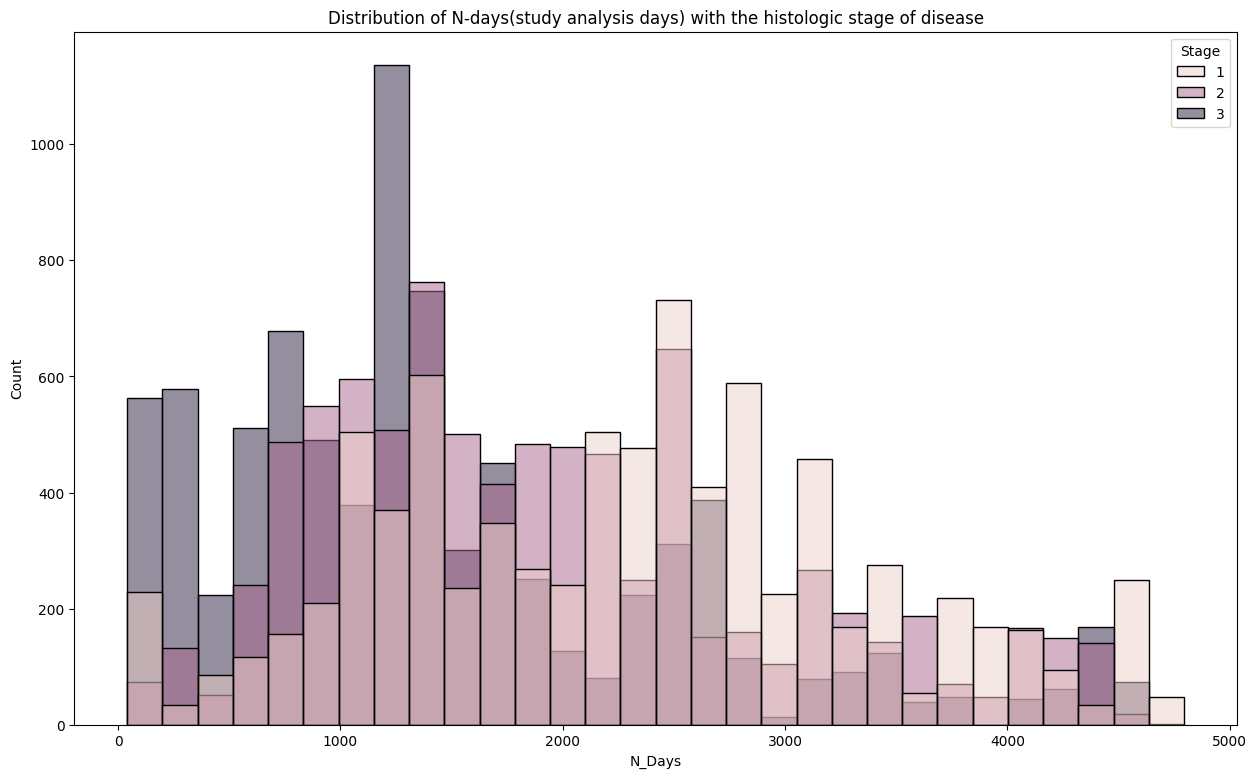

In [6]:
# How N-days(study analysis days) influence the histologic stage of disease
plt.figure(figsize=(15,9))
sns.histplot(x='N_Days', hue='Stage', data=df, bins=30)
plt.title("Distribution of N-days(study analysis days) with the histologic stage of disease");

**Comment:**

Pataients who were studied for less time (days) had the more critical stage (2 or 3) of Liver Cirrhosis.

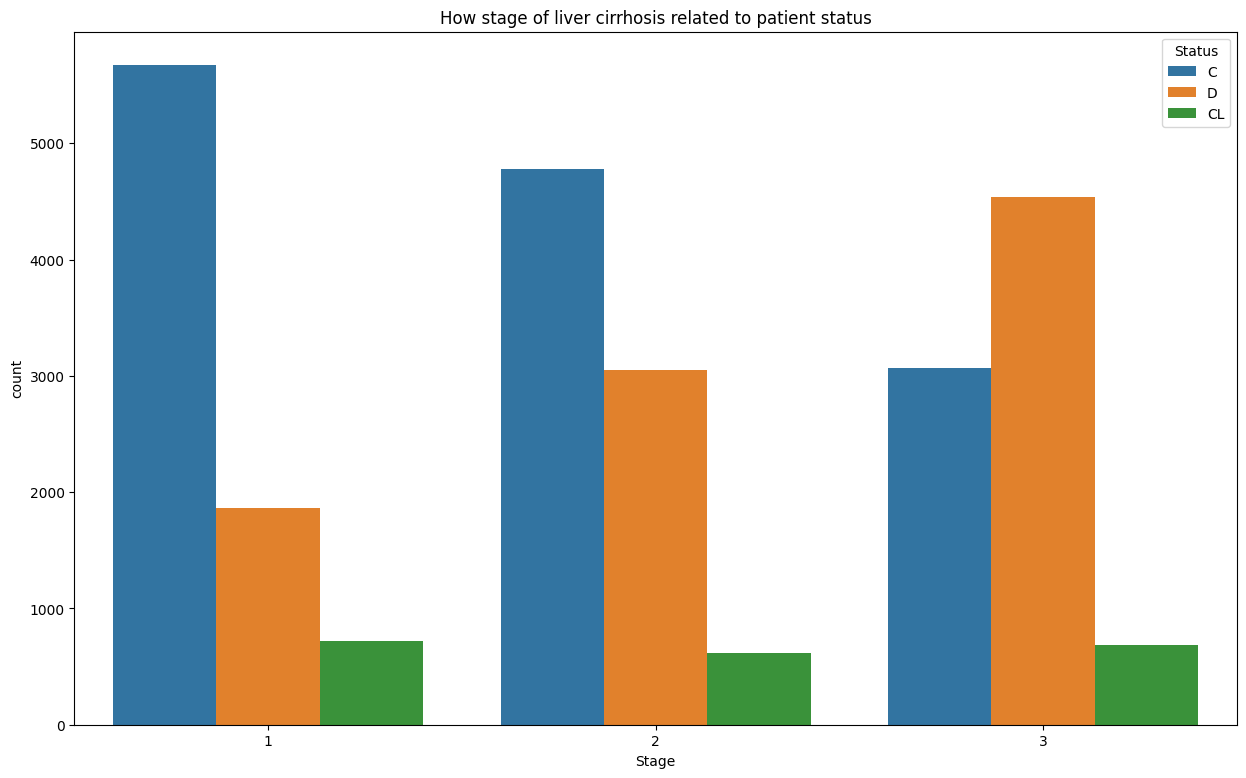

In [7]:
# Status of the patient VS  histologic stage of disease
plt.figure(figsize=(15,9))

sns.countplot(x='Stage', hue='Status', data=df)
plt.title('How stage of liver cirrhosis related to patient status');

**Comment:** 

Patient with liver cirrhosis of stage 3 died more than the liver cirrhosis of stage 2 and 3. This number is less for liver cirrshosis of stage 1.

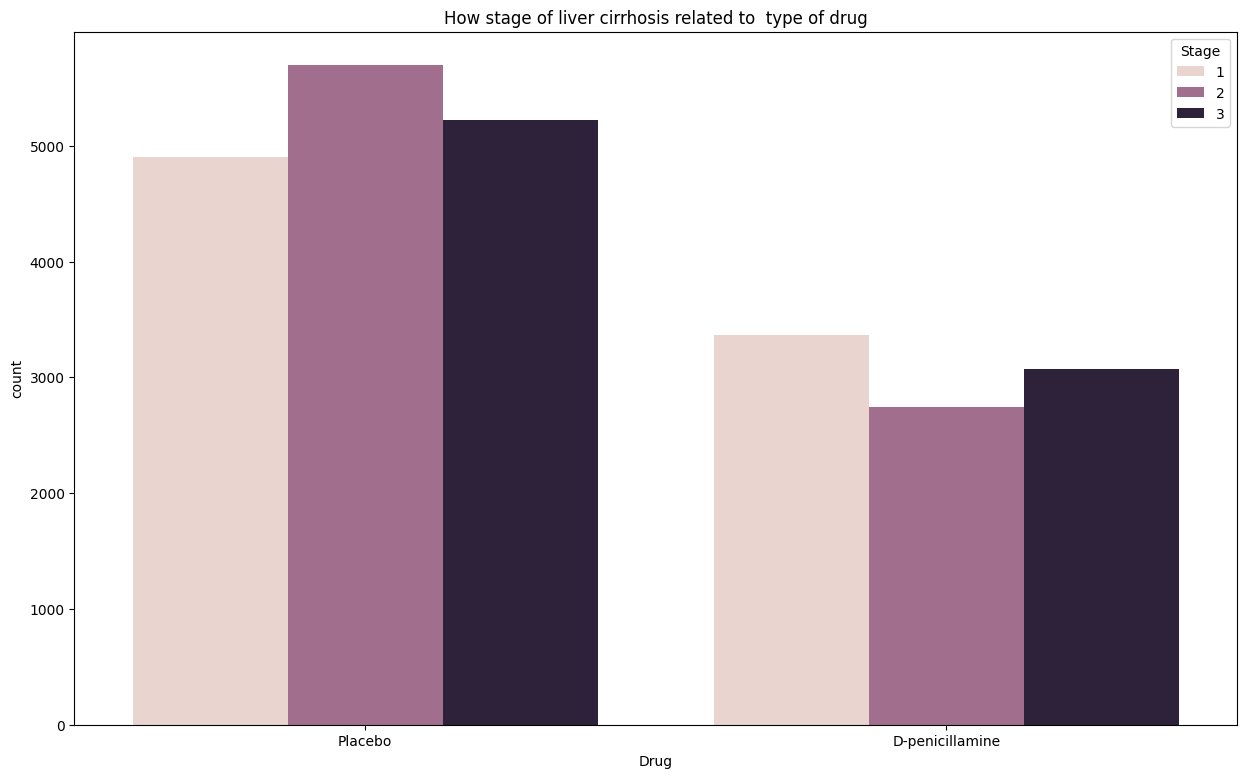

In [8]:
# Drug type VS  histologic stage of disease
plt.figure(figsize=(15,9))

sns.countplot(x='Drug', hue='Stage', data=df)
plt.title('How stage of liver cirrhosis related to  type of drug');

### Check for Multicollinerity

<Axes: >

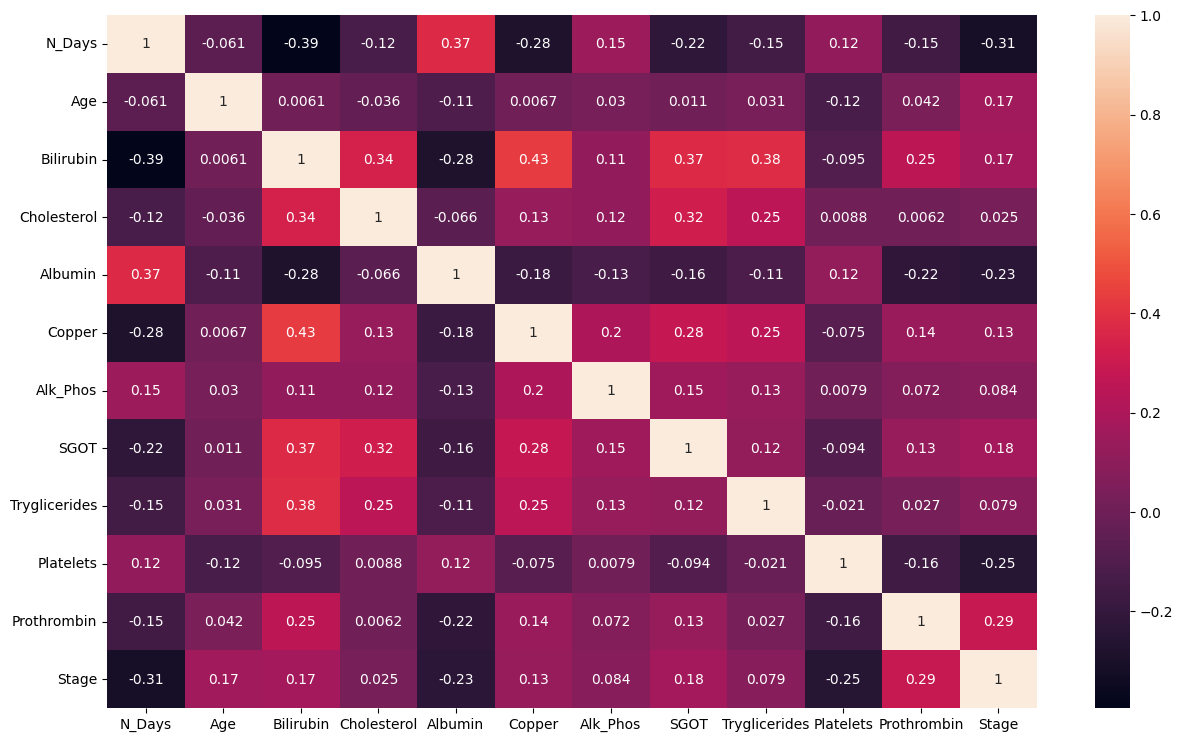

In [9]:
plt.figure(figsize=(15,9))
sns.heatmap(df.select_dtypes('number').corr(), annot=True)

### Check whether data is balanced

In [10]:
df['Stage'].value_counts()

Stage
2    8441
3    8294
1    8265
Name: count, dtype: int64

## Data splitting

In [11]:
# Select features and target
features = num_col + cat_col
target = 'Stage'
# split data into X and y
X = df[features]
y = df[target]

# Shape
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (25000, 18)
y shape:  (25000,)


In [12]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Shape
print("X_trian_shape: ", X_train.shape)
print("y_trian_shape: ", y_train.shape)
print("X_test_shape: ", X_test.shape)
print("y_test_shape: ", y_test.shape)

X_trian_shape:  (20000, 18)
y_trian_shape:  (20000,)
X_test_shape:  (5000, 18)
y_test_shape:  (5000,)


## Model Building and Evaluation

### Model Pipeline

In [13]:
# Column transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_col),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_col),
    
])

# Model pipeline
logis_pipeline = Pipeline([
    ('prepoc', preprocessor),
    ('logis_model', LogisticRegression())
])

# Fit data into the pipeline
logis_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepoc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Status', 'Drug', 'Sex',
                                                   'Ascites', 'Hepatomegaly',
                                                   'Spiders', 'Edema'])])),
                ('logis_model', LogisticRegression())])

### Evaluation

In [14]:
# Training evaluation
y_train_pred = logis_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           1       0.58      0.60      0.59      6612
           2       0.53      0.49      0.51      6753
           3       0.67      0.69      0.68      6635

    accuracy                           0.59     20000
   macro avg       0.59      0.60      0.59     20000
weighted avg       0.59      0.59      0.59     20000



In [15]:
# Testing evaluation
y_test_pred = logis_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.57      0.60      0.58      1653
           2       0.52      0.47      0.49      1688
           3       0.65      0.68      0.66      1659

    accuracy                           0.58      5000
   macro avg       0.58      0.58      0.58      5000
weighted avg       0.58      0.58      0.58      5000



**Comment:**

Model performance is not good, let's try with other non-linear models

## Decision Tree model

In [16]:
# Model pipeline
dtc_pipeline = Pipeline([
    ('prepoc', preprocessor),
    ('dt_model', DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, random_state=42))
])

# Fit data into the pipeline
dtc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepoc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Status', 'Drug', 'Sex',
                                                   'Ascites', 'Hepatomegaly',
                                                   'Spiders', 'Edema'])])),
                ('dt_model',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=3,
                                        random_state=42))])

In [17]:
# Training evaluation
y_train_pred = dtc_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           1       0.84      0.82      0.83      6612
           2       0.81      0.83      0.82      6753
           3       0.87      0.87      0.87      6635

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



In [18]:
# Testing evaluation
y_test_pred = dtc_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.82      0.78      0.80      1653
           2       0.77      0.81      0.79      1688
           3       0.85      0.85      0.85      1659

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



**Comment:**

It is also doing better than logistic regression model. Let's try with random forest classifier.

## Random Forest classifier

In [19]:
# Model pipeline
rfc_pipeline = Pipeline([
    ('prepoc', preprocessor),
    ('rfc_model', RandomForestClassifier(n_estimators=300,max_depth=16, min_samples_leaf=6,random_state=42))
])

# Fit data into the pipeline
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepoc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Status', 'Drug', 'Sex',
                                                   'Ascites', 'Hepatomegaly',
                                                   'Spiders', 'Edema'])])),
                ('rfc_model',
                 RandomForestClassifier(max_depth=16, min_samples_leaf=6,
                                        n_estimators=300, random_state=42))])

In [20]:
# Training evaluation
y_train_pred = rfc_pipeline.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           1       0.97      0.95      0.96      6612
           2       0.95      0.96      0.96      6753
           3       0.97      0.97      0.97      6635

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



In [21]:
# Testing evaluation
y_test_pred = rfc_pipeline.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.95      0.92      0.93      1653
           2       0.91      0.94      0.93      1688
           3       0.95      0.95      0.95      1659

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



**Comment:** 

Model is performing good but we will try to find out more better model using random search cv.

## Random Search CV

In [22]:
# Hyperparameter grid
param_dist = {
    'rfc_model__n_estimators': [200, 300, 400],
    'rfc_model__max_depth': [16,18],
    'rfc_model__min_samples_leaf': [3, 4],
    'rfc_model__min_samples_split': [2, 3, 5]
}

# Randomized Search CV
random_search = RandomizedSearchCV(
    rfc_pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'rfc_model__n_estimators': 400, 'rfc_model__min_samples_split': 5, 'rfc_model__min_samples_leaf': 3, 'rfc_model__max_depth': 18}
Best Score: 0.94475


In [23]:
# get the best model
best_model = random_search.best_estimator_

In [24]:
# Training evaluation
y_train_pred = best_model.predict(X_train)

# Check accuracy
print(classification_report(y_pred=y_train_pred, y_true=y_train))

              precision    recall  f1-score   support

           1       0.98      0.97      0.98      6612
           2       0.97      0.98      0.97      6753
           3       0.99      0.99      0.99      6635

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [25]:
# Testing evaluation
y_test_pred = best_model.predict(X_test)

# Evaluation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.95      0.93      0.94      1653
           2       0.92      0.95      0.94      1688
           3       0.96      0.96      0.96      1659

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



**Comment:**

The overall performance is good. As we are dealing with liver cirrhosis detection, we have to focus more on recall (how many **correctly** predicted as positive based on total actual positive) than precision score (how many **correctly** predicted as positive among total prediction as positive).

As liver cirrhosis with **stage 3** is the most critical condition of a patient and we achived the highest recall score (**96%**) for it and for other stages (1, 2) recall is **95%** and **93%**, we can consider it as a good model for this problem scenario. 

So, we are taking this model as our **final model**. 

### Confusion Matrix

Text(0.5, 1.0, 'CM normalized by row')

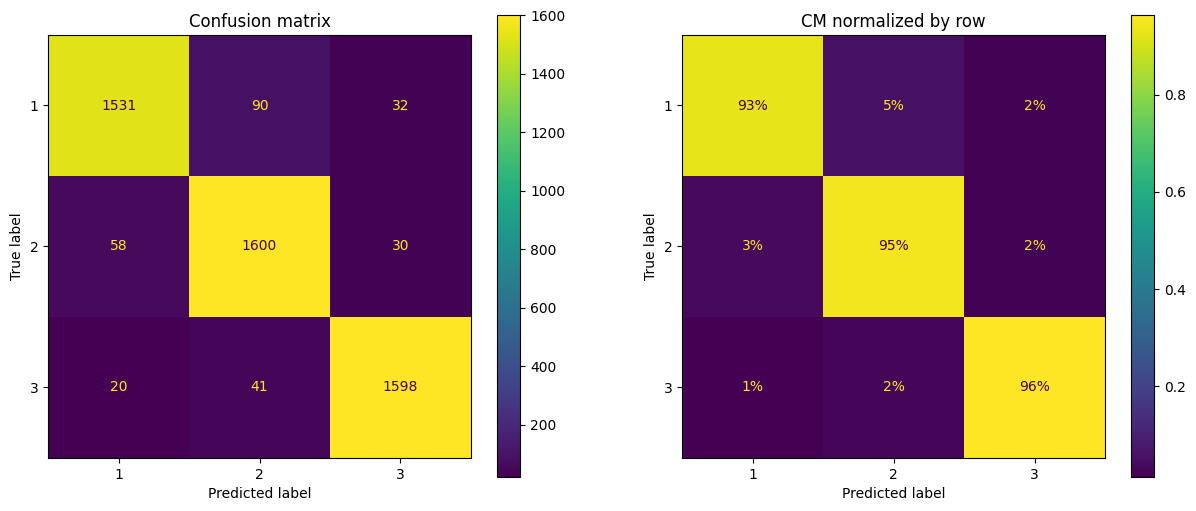

In [44]:
# Create a grid 1*2
fig, axes = plt.subplots(1,2, figsize=(15,6))

# Confusion matrix with count
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axes[0])
axes[0].set_title("Confusion matrix")

# Confusion matrix with normalization by row
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize="true", values_format=".0%", ax=axes[1])
axes[1].set_title("CM normalized by row")


**Comment:**

* The above figure show that almost all stages of Liver Damage (Cirrhosis) are predicted correctly (alogn diagonal of the matrix)
* The mistakes that model has done with stage 1 of liver cirroshosis and that is to misclassify them as stage 2  and that is for 5% of all stage 1. Though this is not serious issue.
* The serious issue that model has done with Stage 2 and stage 3 liver cirrhosis. It has misclassified **3%** of stage 2 liver cirrhosis as stage 1 and missclassified **2%** of stage 3 as stage 2. For this mistakes patients has to deal with critical issue.

### Features importance

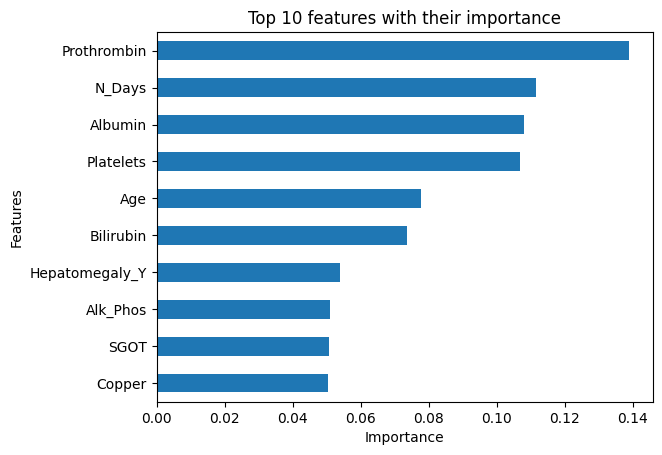

In [74]:
# Calculate features and their importances
feat = best_model.named_steps['prepoc'].get_feature_names_out()
imp = best_model[1].feature_importances_

# Create series
feat_imp = pd.Series(data=imp, index=feat).sort_values(key=abs)
feat_imp.index  = [el[1] for el in feat_imp.index.str.split("__", expand=True)] 

# Plot top 10 most important features with their importce
feat_imp.tail(10).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 10 features with their importance")
plt.show()

## Save and reuse the model

In [77]:
# Save the model
with open("model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

In [78]:
# Load the model
with open("model.pkl", 'rb') as f:
    loaded_model = pickle.load(f)

loaded_model

Pipeline(steps=[('prepoc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Status', 'Drug', 'Sex',
                                                   'Ascites', 'Hepatomegaly',
                                                   'Spiders', 'Edema'])])),
                ('rfc_model',
                 RandomForestClassifier(max_depth=18, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=400,
                                        random_state=42))])

#### Prediction with loaded model

In [79]:
# Test prediction
y_pred = loaded_model.predict(X_test)

# Make a dataframe with actual and predicted values
df_pred = pd.DataFrame(data={'y_actual': y_test, 'y_predicted': y_pred})

# Add predicion status to the pred_df
df_pred['status'] = (df_pred["y_actual"]==df_pred["y_predicted"]).apply(lambda obs: 'Correct prediction' if obs==True else "Wrong prediction" )

# See any random 10 prediction
df_pred.sample(10)

,y_actual,y_predicted,status
15818,2,2,Correct prediction
18467,3,3,Correct prediction
19821,3,3,Correct prediction
14451,1,1,Correct prediction
12113,1,1,Correct prediction
1002,2,2,Correct prediction
17185,1,1,Correct prediction
14568,2,2,Correct prediction
17822,1,1,Correct prediction
9492,3,3,Correct prediction
